In [1]:
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

## Kalman Filter Class

In [2]:
class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u
        
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman
            system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        # mean is zero for noise
        mean_R = np.zeros(np.shape(self.R)[0])
        mean_Q = np.zeros(np.shape(self.Q)[0])
        
        states = np.zeros((len(x0),N))
        states[:,0] = x0
        obs = np.zeros((int(len(x0)/2.), N))
        for i in range(N-1):
            # Calculate random noise
            delta = np.random.multivariate_normal(mean_R, self.R)
            epsilon = np.random.multivariate_normal(mean_Q, self.Q)
            
            # Compute next state and observation
            states[:,i+1] = self.F.dot(states[:,i]) + self.u + epsilon
            obs[:,i+1] = self.H.dot(states[:,i]) + delta
           
        return states, obs


    def estimate(self,x,P,z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        m,N = np.shape(z)
        n = len(x)
        out = np.zeros((n,N))
        I = np.eye(n)
        for i in range(N):
            x_predict = self.F.dot(x) + self.u
            P_predict = self.F.dot(P).dot(self.F.T) + self.Q

            y = z[:,i] - self.H.dot(x_predict)
            S = self.H.dot(P_predict).dot(self.H.T) + self.R
            K = la.solve(S.T, H.dot(P_predict.T)).T # Transposed the equation

            x = x_predict + K.dot(y)
            P = (I - K.dot(H)).dot(P_predict)
            out[:,i] = np.copy(x)
        
        return out

    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        out = np.zeros((len(x),k))
        for i in range(k):
            x = self.F.dot(x) + self.u
            out[:,i] = np.copy(x)
        return out

    def rewind(self,x,k):
        """
        Predict the k states preceding the current state estimate x.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        out = np.zeros((len(x),k))
        for i in range(k):
            x = la.solve(self.F,x-self.u)
            out[:,k-i-1] = np.copy(x)
        return out

## Instantiate a KalmanFilter object with values of Q, R, F, H, u

In [3]:
Q = .1*np.eye(4)
R = 5000*np.eye(2)
F = np.array([[1,0,.1,0],[0,1,0,.1],[0,0,1,0],[0,0,0,1]])
H = np.array([[1,0,0,0],[0,1,0,0]]) # Get s_x and s_y from x
u = np.array([0,0,0,-.98])
kfilter = KalmanFilter(F,Q,H,R,u)

## Simulate the true and observed trajectory of a projectile with initial state x0 = [0 0 300 600]

In [4]:
x0 = np.array([0,0,300,600])
N = 1250
states, obs = kfilter.evolve(x0,N)

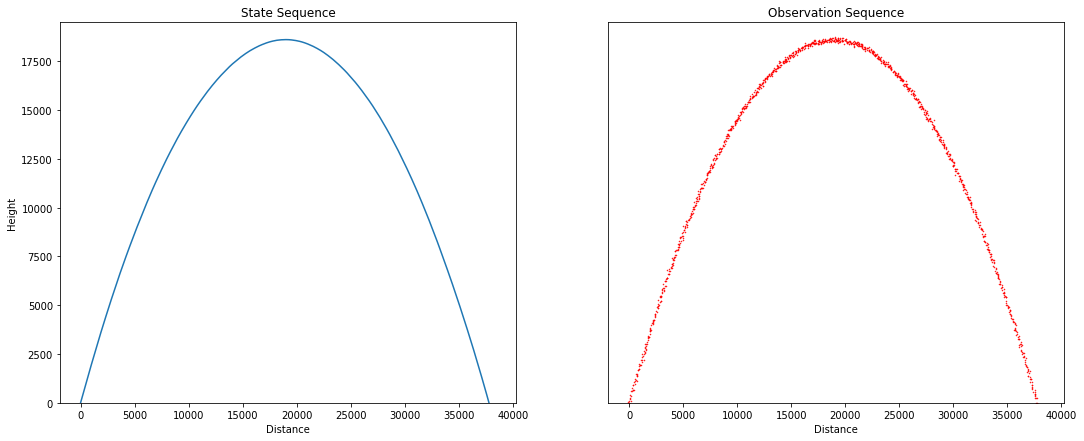

In [5]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(states[0],states[1])
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('State Sequence')

plt.subplot(1,2,2)
plt.plot(obs[0],obs[1],'.r',ms=1)
plt.title('')
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.title('Observation Sequence')
plt.yticks([])
plt.show()

## Use the Kalman filter to estimate the trajectory

In [9]:
x200_800 = states[:,200:800]
# print(np.shape(obs[0,200:209]))
s_x = obs[0,200]
s_y = obs[1,200]
V_x = np.sum(obs[0,200:209])/9.
V_y = np.sum(obs[1,200:209])/9.
est_x200 = np.array([s_x,s_y,V_x,V_y])
P200 = 1e6 * kfilter.Q
out5 = kfilter.estimate(est_x200, P200, obs[:,200:800])

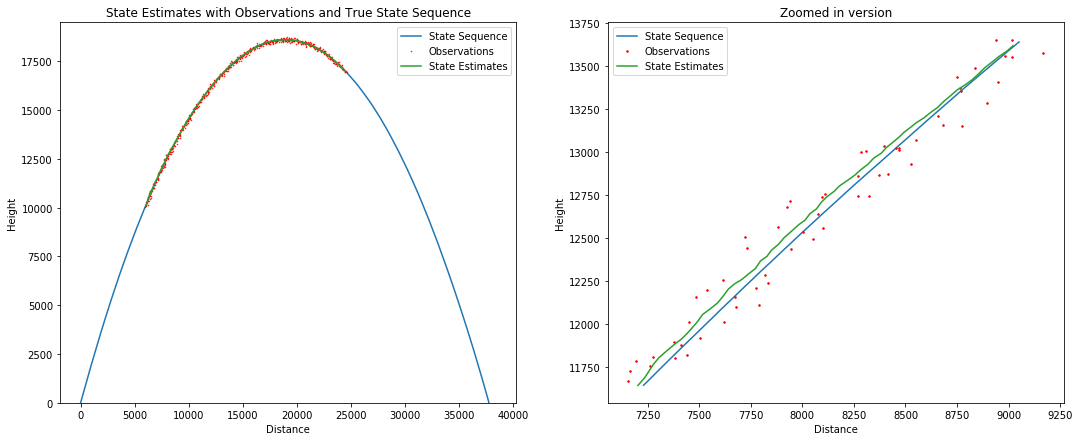

In [10]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(states[0],states[1],label='State Sequence')
# plot radar observations
plt.plot(obs[0,200:800],obs[1,200:800],'.r',ms=1,label='Observations')
# plot estimates
plt.plot(out5[0], out5[1],'tab:green',label='State Estimates')
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('State Estimates with Observations and True State Sequence')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(states[0,240:300],states[1,240:300],ms=3,label='State Sequence')
# plot radar observations
plt.plot(obs[0,240:300],obs[1,240:300],'.r',ms=3,label='Observations')
# plot estimates
plt.plot(out5[0,40:100], out5[1,40:100],'tab:green',label='State Estimates')
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Zoomed in version')
plt.legend(loc='best')

plt.show()

## Predict future states of the projectile

In [11]:
k = 450
out7 = kfilter.predict(out5[:,-1],k)

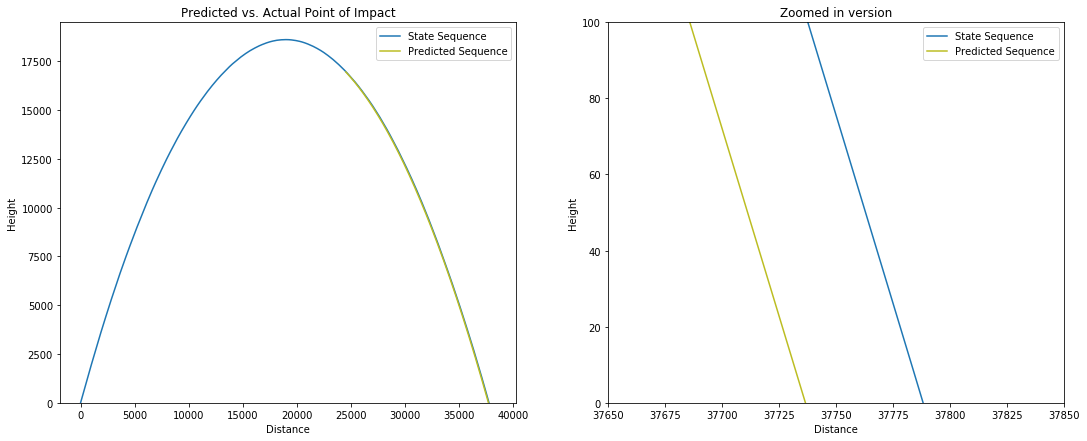

In [27]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(states[0],states[1],label='State Sequence')
# plot estimates
plt.plot(out7[0], out7[1],'tab:olive',label='Predicted Sequence')
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Predicted vs. Actual Point of Impact')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(states[0],states[1],ms=3,label='State Sequence')
# plot estimates
plt.plot(out7[0], out7[1],'tab:olive',label='Predicted Sequence')
plt.xlim([37650,37850])
plt.ylim([0,100])
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Zoomed in version')
plt.legend(loc='best')

plt.show()

## Predict previous states of the projectile

In [13]:
k = 250
out8 = kfilter.rewind(out5[:,50],k)

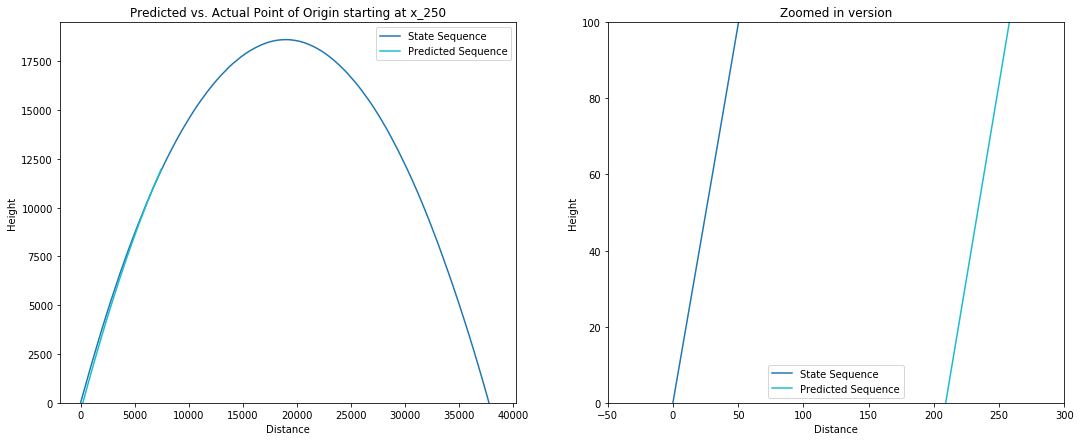

In [25]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(states[0],states[1],label='State Sequence')
# plot estimates
plt.plot(out8[0], out8[1],'tab:cyan',label='Predicted Sequence')
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Predicted vs. Actual Point of Origin starting at x_250')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(states[0],states[1],ms=3,label='State Sequence')
# plot estimates
plt.plot(out8[0], out8[1],'tab:cyan',label='Predicted Sequence')
plt.xlim([-50,300])# 225
plt.ylim([0,100])
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Zoomed in version')
plt.legend(loc='best')

plt.show()

In [16]:
k = 600
out8b = kfilter.rewind(out5[:,400],k)

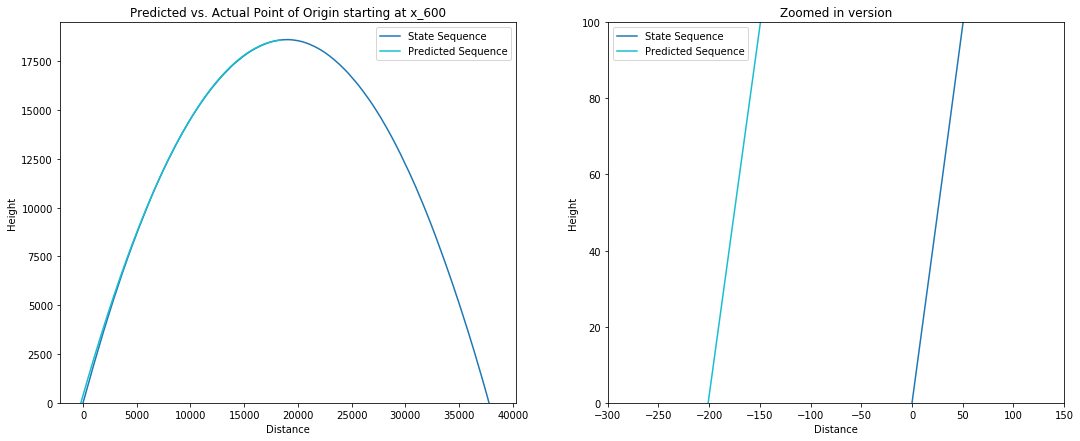

In [24]:
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(states[0],states[1],label='State Sequence')
# plot estimates
plt.plot(out8b[0], out8b[1],'tab:cyan',label='Predicted Sequence')
plt.ylim(0,19500)
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Predicted vs. Actual Point of Origin starting at x_600')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(states[0,0:10],states[1,0:10],ms=3,label='State Sequence')
# plot estimates
plt.plot(out8b[0], out8b[1],'tab:cyan',label='Predicted Sequence')
plt.xlim([-300,150])# 225
plt.ylim([0,100])
plt.xlabel('Distance')
plt.ylabel('Height')
plt.title('Zoomed in version')
plt.legend(loc='best')

plt.show()